In [1]:
import os
import glob
import numpy as np
import pandas as pd
import skimage.morphology


In [2]:
params_file = './params_test.xlsx'

In [3]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((1300, 1)) #70,1
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [4]:
def compute_segment_lengths(starting, ending):
    return ending - starting

def compute_statistics(lengths):
    average = np.mean(lengths)
    std_dev = np.std(lengths)
    return average, std_dev

def compute_large_gaps(starting, ending, gap_threshold=1300):
    gaps = starting[1:] - ending[:-1]
    print(gaps)
    large_gaps = np.sum(gaps > gap_threshold)
    return large_gaps


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_boundaries(raw_data_list, processed_data, file_number):
    channel_names = ["Trigger (Machine)", "Flat Response Microphone (Front)", 
                     "Flat Response Microphone (Rear)", "Resonant Microphone"]
    
    sampling_freq = 200000  # Sampling frequency in Hz
    fig, axs = plt.subplots(len(raw_data_list), 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f'Signal {file_number}', fontsize=16)
    plt.subplots_adjust(hspace=0.5)

    for j, signal_data in enumerate(raw_data_list):
        channel_index = j + 1  # Adjusting for 0-based index
        starting, ending = processed_data.get(f'Channel_{channel_index}', {}).get('boundaries', ([], []))
        
        # Convert sample indices to time
        time_axis = np.arange(len(signal_data)) / sampling_freq
        
        # Plot using time_axis for the x-axis
        axs[j].plot(time_axis, signal_data, label=f'Channel {channel_index} - {channel_names[channel_index]}')
        
        # Convert starting and ending indices to time
        starting_time = starting / sampling_freq
        ending_time = ending / sampling_freq
        
        # Scatter plot for starting and ending points using converted time
        axs[j].scatter(starting_time, signal_data[starting], color='g', label='Starting', zorder=5)
        axs[j].scatter(ending_time, signal_data[ending], color='r', label='Ending', zorder=5)
        
        axs[j].legend(loc="upper right")
        axs[j].set_title(channel_names[channel_index]+ " " +processed_data.get(f'Channel_{channel_index}', {}).get('Operation', ([])))
        axs[j].set_ylabel('Amplitude (V)')
        axs[j].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()


In [6]:
import os
import pandas as pd
import warnings


def process_file(channels, file_name, threshold, excel_path):
    th = 10000
    # Read the corresponding row from the Excel file based on file_number
    excel_data = pd.read_excel(excel_path)
    
    # Use regular expression to find all numbers in the string
    numbers_in_string = re.findall(r'\d+', file_name)

    # Convert the first found number to integer
    file_number = int(numbers_in_string[0]) if numbers_in_string else None
    row = excel_data.iloc[file_number]
    operation = row['Operation']
    cube_1_mode = row['Cube 1 Mode']
    cube_2_mode = row['Cube 2 Mode']

    file_data = {}
    raw_data_list = []  # To store raw data for each channel
    print(f"\nProcessing File: {file_name}, Operation: {operation}, Cube 1 Mode: {cube_1_mode}, Cube 2 Mode: {cube_2_mode}")

    for channel_index, channel_path in enumerate(channels):
        if channel_index == 0:  # Skip Channel 0
            print("Skipping Channel 0 as per requirements.")
            continue
        
        channel_file_path = os.path.join(channel_path, f"{file_name}.parquet")
        print(f"Reading data from {channel_file_path} for Channel {channel_index}")
        channel_data = pd.read_parquet(channel_file_path)
        signal_data = channel_data.iloc[:, 0].values  # The signal data is in the first column
        raw_data_list.append(signal_data)  # Store raw data

        # Compute boundaries and segments
        if channel_index == 3:  # Use Channel 2's boundaries for Channel 3
            starting, ending = file_data['Channel_2']['boundaries']
            print("Using vecchia ciabatta")
        else:
            starting, ending = computeBoundaries(signal_data, threshold)
        
        segments = [signal_data[start:end+1] for start, end in zip(starting, ending) if end-start+1 >= th]
        starting_pruned = np.array([start for start, end in zip(starting, ending) if end-start+1 >= th])
        ending_pruned = np.array([end for start, end in zip(starting, ending) if end-start+1 >= th])
        
#         if len(segments) < len(starting):  # If any segments are excluded
#             warnings.warn(f"Warning: Excluded segment smaller than {th} points.")
        
        segment_lengths = [len(segment) for segment in segments]
        avg_length, std_dev = compute_statistics(segment_lengths)
        num_segments = len(segments)

        # Add extracted information and processed data to file_data
        file_data[f'Channel_{channel_index}'] = {
            'Operation': operation,
            'Cube 1 Mode': cube_1_mode,
            'Cube 2 Mode': cube_2_mode,
            'segments': segments,
            'boundaries': (starting_pruned, ending_pruned),
            'avg_length': avg_length,
            'std_dev': std_dev,
            'num_segments': num_segments
        }

        print(f"Channel {channel_index}: Processed with {len(segments)} segments detected.")
        print(f"Average Segment Length: {avg_length:.2f}, Standard Deviation: {std_dev:.2f}, Num. segments: {num_segments}")
        
        # Large gaps validation after excluding small segments
        if (operation == "Sequential" and num_segments != 2) or (operation == "Simultaneous" and num_segments != 1):
            warnings.warn(f"Warning: Expected segment count not met for {operation} operation. Num. segments: {num_segments}")

    return file_data, raw_data_list


In [7]:
import random
import glob
import os
import re

from tqdm import tqdm


def parse_multimodal_signals_corrected_with_plotting(path, threshold=1.0, N=10):
    channels = glob.glob(os.path.join(path, "*/"))
    channels.sort()
    
    sample_files = glob.glob(os.path.join(channels[0], "*.parquet"))
    sample_files.sort(key=lambda x: int(re.search(r'File_(\d+)', x).group(1)))
        
    all_processed_data = {}
    problematic_files = []  # List to store file numbers of problematic files

    for sample_file in tqdm(sample_files, desc="Processing files"):
        
        file_name = os.path.splitext(os.path.basename(sample_file))[0]
        try:
            processed_data, raw_data_list = process_file(channels, file_name, threshold, params_file)

            # Initialize a flag to track if the file is problematic
            is_problematic = False

            # Iterate through processed data to check large gaps for each channel
            for channel_key, channel_info in processed_data.items():
                if channel_key == 'Channel_0':
                    continue  # Skip Channel 0 as per original requirement

                # Extract operation type for the current file from the processed_data
                operation_type = channel_info['Operation']

                # Determine the expected number of large gaps
                expected_segments = 2 if operation_type == 'Sequential' else 1

                if channel_info['num_segments'] != expected_segments:
                    print(f"Warning: File_{file_name} in {channel_key} has {channel_info['num_segments']} segments instead of {expected_segments}.")
                    problematic_files.append(file_name)
                    is_problematic = True
                    break  # Assuming if one channel is problematic, the file is considered problematic

            if not is_problematic:
                all_processed_data[file_name] = processed_data
                
        except IndexError as e:
            print(f"Error processing File_{file_number}: {e}")
            problematic_files.append(file_number)  # Add to problematic files if an IndexError occurs
        
        if (len(all_processed_data) + len(problematic_files)) % 10 == 0:  # Plot after processing every 10 files
            print(f"Plotting signals processed up to file number: {file_name}")
            plot_signals_with_boundaries(raw_data_list, processed_data, file_name)
            print('----'*32)
        
    if problematic_files:
        print(f"Problematic files (large gaps not as expected): {problematic_files}")
    
    return all_processed_data


Processing files:   0%|                                                                     | 0/160 [00:00<?, ?it/s]


Processing File: File_0, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_0.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428089.50, Standard Deviation: 434.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_0.parquet for Channel 2


Processing files:   1%|▍                                                            | 1/160 [00:15<41:27, 15.64s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426727.50, Standard Deviation: 606.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_0.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426727.50, Standard Deviation: 606.50, Num. segments: 2

Processing File: File_1, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_1.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427406.50, Standard Deviation: 524.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_1.parquet for Channel 2


Processing files:   1%|▊                                                            | 2/160 [00:31<40:53, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426475.00, Standard Deviation: 117.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_1.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426475.00, Standard Deviation: 117.00, Num. segments: 2

Processing File: File_2, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_2.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428706.00, Standard Deviation: 839.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_2.parquet for Channel 2


Processing files:   2%|█▏                                                           | 3/160 [00:46<40:31, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 427677.50, Standard Deviation: 786.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_2.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427677.50, Standard Deviation: 786.50, Num. segments: 2

Processing File: File_3, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_3.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427492.50, Standard Deviation: 583.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_3.parquet for Channel 2


Processing files:   2%|█▌                                                           | 4/160 [01:01<40:11, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425905.00, Standard Deviation: 233.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_3.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425905.00, Standard Deviation: 233.00, Num. segments: 2

Processing File: File_4, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_4.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427749.50, Standard Deviation: 828.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_4.parquet for Channel 2


Processing files:   3%|█▉                                                           | 5/160 [01:17<39:54, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 427124.00, Standard Deviation: 370.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_4.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427124.00, Standard Deviation: 370.00, Num. segments: 2

Processing File: File_5, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_5.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427360.50, Standard Deviation: 373.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_5.parquet for Channel 2


Processing files:   4%|██▎                                                          | 6/160 [01:32<39:37, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425274.00, Standard Deviation: 390.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_5.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425274.00, Standard Deviation: 390.00, Num. segments: 2

Processing File: File_6, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_6.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427686.50, Standard Deviation: 984.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_6.parquet for Channel 2


Processing files:   4%|██▋                                                          | 7/160 [01:48<39:20, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426691.00, Standard Deviation: 699.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_6.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426691.00, Standard Deviation: 699.00, Num. segments: 2

Processing File: File_7, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_7.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426735.50, Standard Deviation: 416.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_7.parquet for Channel 2


Processing files:   5%|███                                                          | 8/160 [02:03<39:03, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425209.50, Standard Deviation: 195.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_7.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425209.50, Standard Deviation: 195.50, Num. segments: 2

Processing File: File_8, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_8.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428110.00, Standard Deviation: 325.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_8.parquet for Channel 2


Processing files:   6%|███▍                                                         | 9/160 [02:18<38:46, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426120.00, Standard Deviation: 1120.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_8.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426120.00, Standard Deviation: 1120.00, Num. segments: 2

Processing File: File_9, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_9.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427190.50, Standard Deviation: 543.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_9.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 425127.50, Standard Deviation: 203.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_9.parquet for Channel 3
Using vecchia ciabatta
Channel 3:

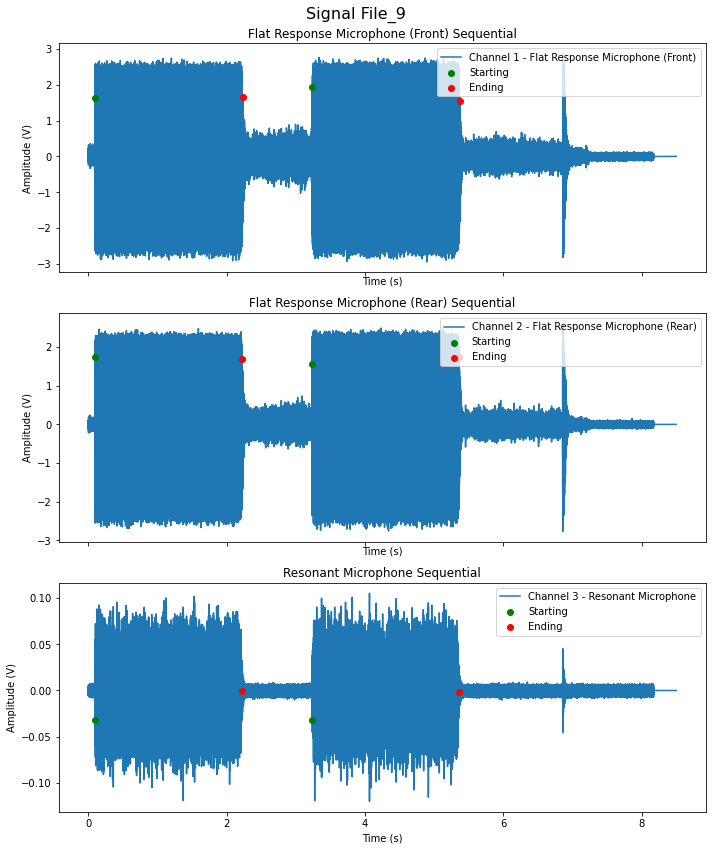

Processing files:   6%|███▊                                                        | 10/160 [02:35<39:18, 15.72s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_10, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_10.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429886.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_10.parquet for Channel 2


Processing files:   7%|████▏                                                       | 11/160 [02:50<38:48, 15.62s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427764.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_10.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427764.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_11, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_11.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429249.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_11.parquet for Channel 2


Processing files:   8%|████▌                                                       | 12/160 [03:06<38:21, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428113.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_11.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428113.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_12, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_12.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 431215.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_12.parquet for Channel 2


Processing files:   8%|████▉                                                       | 13/160 [03:21<37:59, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428419.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_12.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428419.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_13, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_13.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428476.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_13.parquet for Channel 2


Processing files:   9%|█████▎                                                      | 14/160 [03:36<37:38, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427551.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_13.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427551.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_14, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_14.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429494.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_14.parquet for Channel 2


Processing files:   9%|█████▋                                                      | 15/160 [03:52<37:19, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427748.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_14.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427748.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_15, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_15.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429324.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_15.parquet for Channel 2


Processing files:  10%|██████                                                      | 16/160 [04:07<37:03, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 426735.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_15.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 426735.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_16, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_16.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430694.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_16.parquet for Channel 2


Processing files:  11%|██████▍                                                     | 17/160 [04:23<36:45, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429024.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_16.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429024.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_17, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_17.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428518.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_17.parquet for Channel 2


Processing files:  11%|██████▊                                                     | 18/160 [04:38<36:28, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427615.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_17.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427615.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_18, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_18.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430746.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_18.parquet for Channel 2


Processing files:  12%|███████▏                                                    | 19/160 [04:53<36:12, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429017.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_18.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429017.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_19, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_19.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428263.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_19.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 427689.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_19.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pr

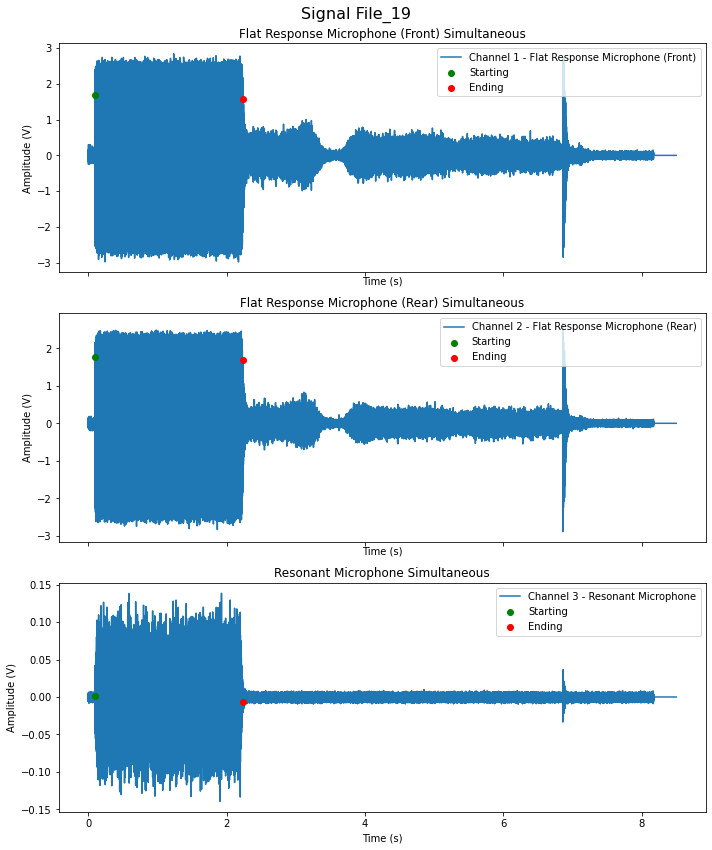

Processing files:  12%|███████▌                                                    | 20/160 [05:10<36:32, 15.66s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_20, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_20.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427058.50, Standard Deviation: 838.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_20.parquet for Channel 2


Processing files:  13%|███████▉                                                    | 21/160 [05:25<36:06, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426158.00, Standard Deviation: 481.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_20.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426158.00, Standard Deviation: 481.00, Num. segments: 2

Processing File: File_21, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_21.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427547.00, Standard Deviation: 1105.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_21.parquet for Channel 2


Processing files:  14%|████████▎                                                   | 22/160 [05:41<35:43, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424387.00, Standard Deviation: 554.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_21.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424387.00, Standard Deviation: 554.00, Num. segments: 2

Processing File: File_22, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_22.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427737.50, Standard Deviation: 1283.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_22.parquet for Channel 2


Processing files:  14%|████████▋                                                   | 23/160 [05:56<35:25, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425724.00, Standard Deviation: 934.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_22.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425724.00, Standard Deviation: 934.00, Num. segments: 2

Processing File: File_23, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_23.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426191.50, Standard Deviation: 12.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_23.parquet for Channel 2


Processing files:  15%|█████████                                                   | 24/160 [06:11<35:05, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424636.50, Standard Deviation: 719.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_23.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424636.50, Standard Deviation: 719.50, Num. segments: 2

Processing File: File_24, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_24.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427342.00, Standard Deviation: 571.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_24.parquet for Channel 2


Processing files:  16%|█████████▍                                                  | 25/160 [06:27<34:49, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425498.00, Standard Deviation: 331.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_24.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425498.00, Standard Deviation: 331.00, Num. segments: 2

Processing File: File_25, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_25.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426260.00, Standard Deviation: 1200.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_25.parquet for Channel 2


Processing files:  16%|█████████▊                                                  | 26/160 [06:42<34:32, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424534.00, Standard Deviation: 565.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_25.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424534.00, Standard Deviation: 565.00, Num. segments: 2

Processing File: File_26, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_26.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426968.50, Standard Deviation: 927.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_26.parquet for Channel 2


Processing files:  17%|██████████▏                                                 | 27/160 [06:58<34:14, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425946.00, Standard Deviation: 841.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_26.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425946.00, Standard Deviation: 841.00, Num. segments: 2

Processing File: File_27, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_27.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 425453.50, Standard Deviation: 360.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_27.parquet for Channel 2


Processing files:  18%|██████████▌                                                 | 28/160 [07:13<33:58, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425317.50, Standard Deviation: 987.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_27.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425317.50, Standard Deviation: 987.50, Num. segments: 2

Processing File: File_28, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_28.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427639.00, Standard Deviation: 111.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_28.parquet for Channel 2


Processing files:  18%|██████████▉                                                 | 29/160 [07:29<33:42, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425853.50, Standard Deviation: 522.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_28.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425853.50, Standard Deviation: 522.50, Num. segments: 2

Processing File: File_29, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_29.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426625.00, Standard Deviation: 734.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_29.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 424967.00, Standard Deviation: 874.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_29.parquet for Channel 3
Using vecchia ciabatta
Channel

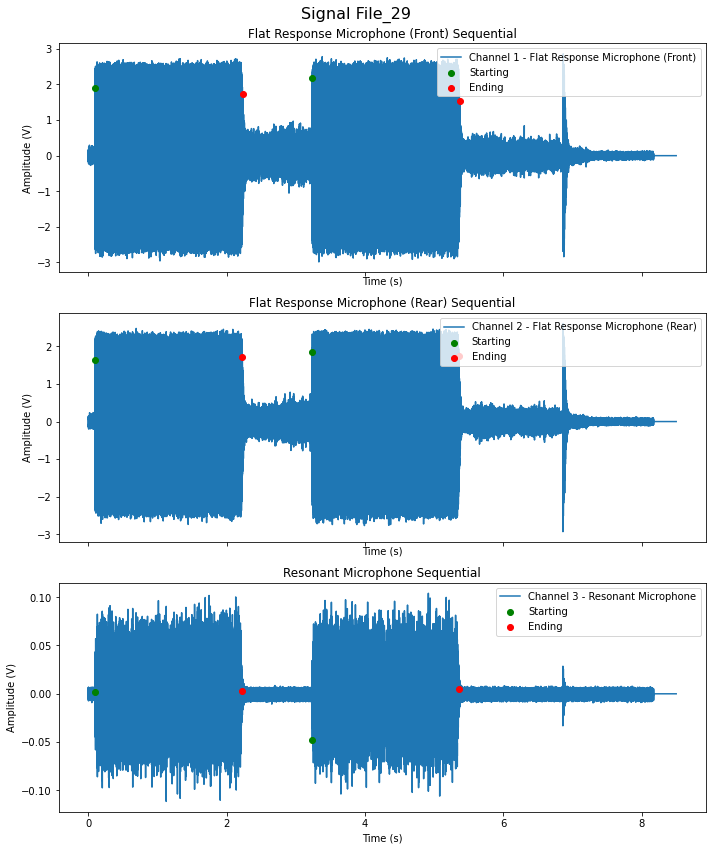

Processing files:  19%|███████████▎                                                | 30/160 [07:45<34:08, 15.76s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_30, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_30.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429950.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_30.parquet for Channel 2


Processing files:  19%|███████████▋                                                | 31/160 [08:00<33:38, 15.65s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427601.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_30.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427601.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_31, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_31.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428731.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_31.parquet for Channel 2


Processing files:  20%|████████████                                                | 32/160 [08:16<33:13, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427181.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_31.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427181.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_32, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_32.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430161.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_32.parquet for Channel 2


Processing files:  21%|████████████▍                                               | 33/160 [08:31<32:50, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429105.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_32.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429105.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_33, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_33.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429109.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_33.parquet for Channel 2


Processing files:  21%|████████████▊                                               | 34/160 [08:47<32:28, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 426558.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_33.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 426558.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_34, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_34.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429994.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_34.parquet for Channel 2


Processing files:  22%|█████████████▏                                              | 35/160 [09:02<32:09, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428778.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_34.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428778.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_35, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_35.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429527.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_35.parquet for Channel 2


Processing files:  22%|█████████████▌                                              | 36/160 [09:17<31:50, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427686.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_35.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427686.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_36, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_36.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430177.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_36.parquet for Channel 2


Processing files:  23%|█████████████▉                                              | 37/160 [09:33<31:34, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427659.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_36.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427659.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_37, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_37.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428823.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_37.parquet for Channel 2


Processing files:  24%|██████████████▎                                             | 38/160 [09:48<31:19, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427634.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_37.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427634.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_38, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_38.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429607.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_38.parquet for Channel 2


Processing files:  24%|██████████████▋                                             | 39/160 [10:04<31:04, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428009.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_38.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428009.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_39, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_39.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429937.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_39.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 427796.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_39.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pr

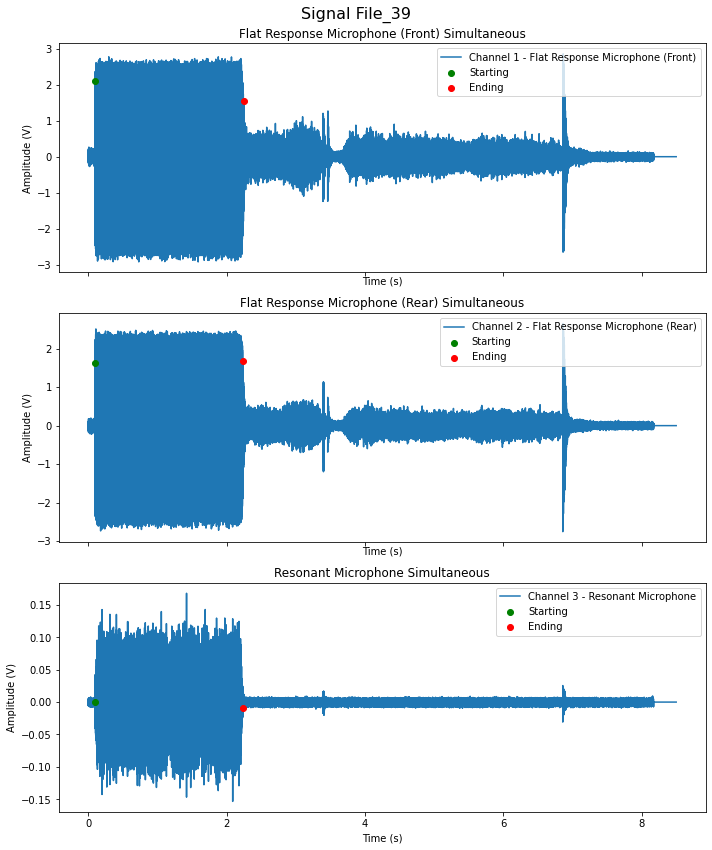

Processing files:  25%|███████████████                                             | 40/160 [10:20<31:20, 15.67s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_40, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_40.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 403327.50, Standard Deviation: 963.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_40.parquet for Channel 2


Processing files:  26%|███████████████▎                                            | 41/160 [10:35<30:56, 15.60s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401767.00, Standard Deviation: 56.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_40.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401767.00, Standard Deviation: 56.00, Num. segments: 2

Processing File: File_41, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_41.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402225.00, Standard Deviation: 214.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_41.parquet for Channel 2


Processing files:  26%|███████████████▊                                            | 42/160 [10:51<30:33, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 400812.00, Standard Deviation: 754.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_41.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 400812.00, Standard Deviation: 754.00, Num. segments: 2

Processing File: File_42, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_42.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402820.50, Standard Deviation: 319.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_42.parquet for Channel 2


Processing files:  27%|████████████████▏                                           | 43/160 [11:06<30:12, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401274.50, Standard Deviation: 504.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_42.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401274.50, Standard Deviation: 504.50, Num. segments: 2

Processing File: File_43, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_43.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 401513.00, Standard Deviation: 438.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_43.parquet for Channel 2


Processing files:  28%|████████████████▌                                           | 44/160 [11:21<29:53, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 400461.50, Standard Deviation: 182.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_43.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 400461.50, Standard Deviation: 182.50, Num. segments: 2

Processing File: File_44, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_44.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402475.50, Standard Deviation: 1196.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_44.parquet for Channel 2


Processing files:  28%|████████████████▉                                           | 45/160 [11:37<29:35, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401706.50, Standard Deviation: 489.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_44.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401706.50, Standard Deviation: 489.50, Num. segments: 2

Processing File: File_45, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_45.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402111.50, Standard Deviation: 1308.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_45.parquet for Channel 2


Processing files:  29%|█████████████████▎                                          | 46/160 [11:52<29:20, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401039.50, Standard Deviation: 987.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_45.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401039.50, Standard Deviation: 987.50, Num. segments: 2

Processing File: File_46, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_46.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402479.00, Standard Deviation: 402.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_46.parquet for Channel 2


Processing files:  29%|█████████████████▋                                          | 47/160 [12:08<29:04, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401723.00, Standard Deviation: 754.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_46.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401723.00, Standard Deviation: 754.00, Num. segments: 2

Processing File: File_47, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_47.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 401543.50, Standard Deviation: 827.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_47.parquet for Channel 2


Processing files:  30%|██████████████████                                          | 48/160 [12:23<28:49, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 400549.50, Standard Deviation: 328.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_47.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 400549.50, Standard Deviation: 328.50, Num. segments: 2

Processing File: File_48, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_48.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 403003.00, Standard Deviation: 809.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_48.parquet for Channel 2


Processing files:  31%|██████████████████▍                                         | 49/160 [12:39<28:31, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401706.50, Standard Deviation: 928.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_48.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401706.50, Standard Deviation: 928.50, Num. segments: 2

Processing File: File_49, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_49.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 401520.00, Standard Deviation: 701.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_49.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 400063.00, Standard Deviation: 673.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_49.parquet for Channel 3
Using vecchia ciabatta
Channel

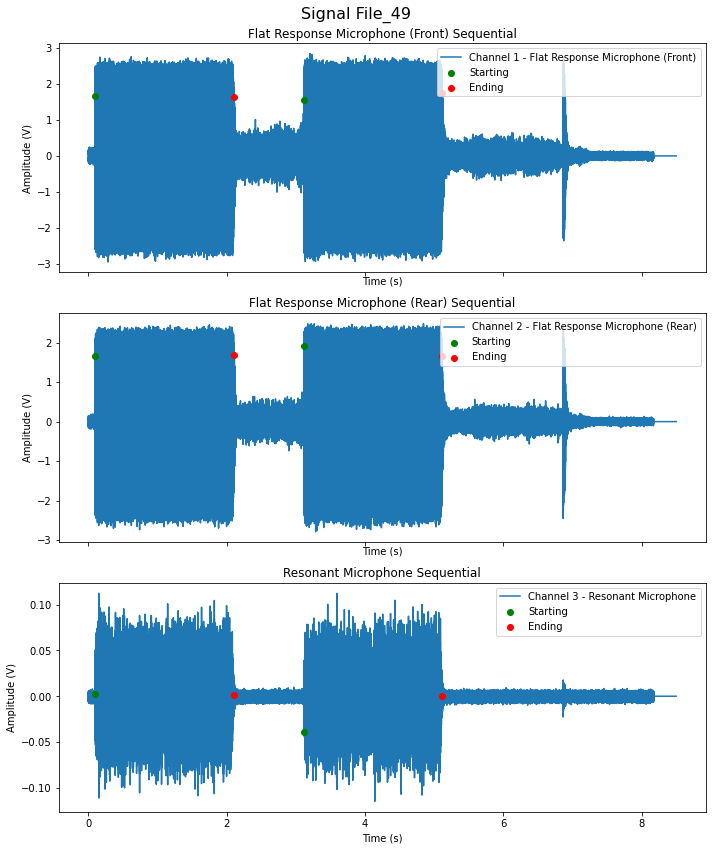

Processing files:  31%|██████████████████▊                                         | 50/160 [12:55<28:48, 15.71s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_50, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_50.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402346.50, Standard Deviation: 730.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_50.parquet for Channel 2


Processing files:  32%|███████████████████▏                                        | 51/160 [13:10<28:22, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401476.00, Standard Deviation: 824.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_50.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401476.00, Standard Deviation: 824.00, Num. segments: 2

Processing File: File_51, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_51.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 401808.00, Standard Deviation: 431.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_51.parquet for Channel 2


Processing files:  32%|███████████████████▌                                        | 52/160 [13:26<28:00, 15.56s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401148.00, Standard Deviation: 948.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_51.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401148.00, Standard Deviation: 948.00, Num. segments: 2

Processing File: File_52, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_52.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402815.50, Standard Deviation: 850.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_52.parquet for Channel 2


Processing files:  33%|███████████████████▉                                        | 53/160 [13:41<27:40, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401360.00, Standard Deviation: 472.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_52.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401360.00, Standard Deviation: 472.00, Num. segments: 2

Processing File: File_53, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_53.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402422.00, Standard Deviation: 1462.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_53.parquet for Channel 2


Processing files:  34%|████████████████████▎                                       | 54/160 [13:57<27:22, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 401102.00, Standard Deviation: 274.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_53.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 401102.00, Standard Deviation: 274.00, Num. segments: 2

Processing File: File_54, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_54.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 402549.00, Standard Deviation: 330.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_54.parquet for Channel 2


Processing files:  34%|████████████████████▋                                       | 55/160 [14:12<27:06, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 402009.00, Standard Deviation: 687.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_54.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 402009.00, Standard Deviation: 687.00, Num. segments: 2

Processing File: File_55, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_55.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 403698.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_55.parquet for Channel 2


Processing files:  35%|█████████████████████                                       | 56/160 [14:28<26:49, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 402003.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_55.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 402003.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_56, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_56.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 406211.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_56.parquet for Channel 2


Processing files:  36%|█████████████████████▍                                      | 57/160 [14:43<26:31, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 403996.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_56.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 403996.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_57, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_57.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404671.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_57.parquet for Channel 2


Processing files:  36%|█████████████████████▊                                      | 58/160 [14:58<26:14, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 403249.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_57.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 403249.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_58, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_58.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 405923.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_58.parquet for Channel 2


Processing files:  37%|██████████████████████▏                                     | 59/160 [15:14<25:57, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 404051.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_58.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 404051.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_59, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_59.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404680.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_59.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 402368.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_59.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pr

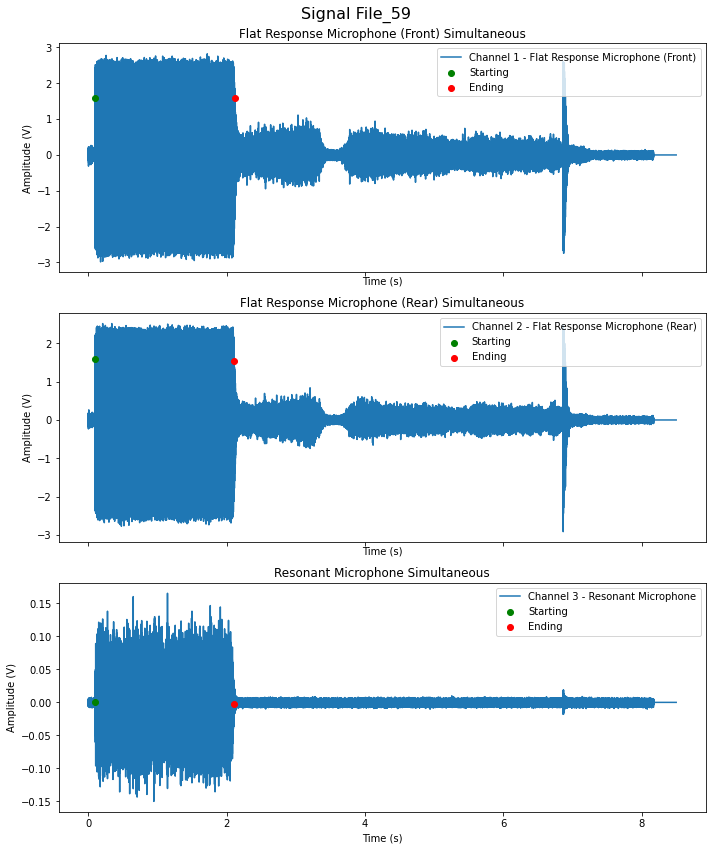

Processing files:  38%|██████████████████████▌                                     | 60/160 [15:30<26:09, 15.69s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_60, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_60.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 405916.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_60.parquet for Channel 2


Processing files:  38%|██████████████████████▉                                     | 61/160 [15:45<25:44, 15.60s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 404637.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_60.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 404637.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_61, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_61.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404877.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_61.parquet for Channel 2


Processing files:  39%|███████████████████████▎                                    | 62/160 [16:01<25:23, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 403706.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_61.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 403706.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_62, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_62.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 405632.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_62.parquet for Channel 2


Processing files:  39%|███████████████████████▋                                    | 63/160 [16:16<25:02, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 404937.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_62.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 404937.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_63, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_63.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404242.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_63.parquet for Channel 2


Processing files:  40%|████████████████████████                                    | 64/160 [16:32<24:43, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 401770.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_63.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 401770.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_64, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_64.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404940.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_64.parquet for Channel 2


Processing files:  41%|████████████████████████▍                                   | 65/160 [16:47<24:25, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 404231.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_64.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 404231.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_65, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_65.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404285.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_65.parquet for Channel 2


Processing files:  41%|████████████████████████▊                                   | 66/160 [17:02<24:08, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 402354.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_65.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 402354.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_66, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_66.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 407091.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_66.parquet for Channel 2


Processing files:  42%|█████████████████████████▏                                  | 67/160 [17:18<23:50, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 404862.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_66.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 404862.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_67, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_67.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404363.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_67.parquet for Channel 2


Processing files:  42%|█████████████████████████▌                                  | 68/160 [17:33<23:34, 15.37s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 402663.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_67.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 402663.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_68, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_68.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 405597.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_68.parquet for Channel 2


Processing files:  43%|█████████████████████████▉                                  | 69/160 [17:48<23:19, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 403392.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_68.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 403392.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_69, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_69.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 404459.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_69.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 403235.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_69.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pr

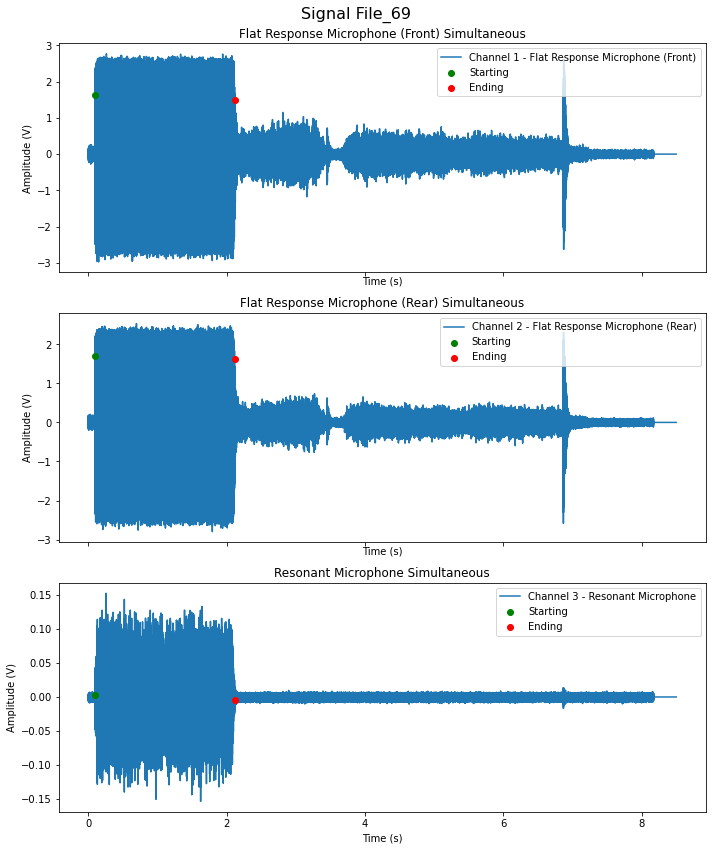

Processing files:  44%|██████████████████████████▎                                 | 70/160 [18:05<23:27, 15.64s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_70, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_70.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536917.00, Standard Deviation: 134428.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_70.parquet for Channel 2


Processing files:  44%|██████████████████████████▋                                 | 71/160 [18:20<23:06, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535658.00, Standard Deviation: 134691.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_70.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535658.00, Standard Deviation: 134691.00, Num. segments: 2

Processing File: File_71, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_71.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536661.00, Standard Deviation: 134074.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_71.parquet for Channel 2


Processing files:  45%|███████████████████████████                                 | 72/160 [18:35<22:45, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535533.00, Standard Deviation: 133908.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_71.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535533.00, Standard Deviation: 133908.00, Num. segments: 2

Processing File: File_72, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_72.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536256.00, Standard Deviation: 133645.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_72.parquet for Channel 2


Processing files:  46%|███████████████████████████▍                                | 73/160 [18:51<22:26, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535820.50, Standard Deviation: 133479.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_72.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535820.50, Standard Deviation: 133479.50, Num. segments: 2

Processing File: File_73, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_73.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535994.00, Standard Deviation: 133356.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_73.parquet for Channel 2


Processing files:  46%|███████████████████████████▊                                | 74/160 [19:06<22:08, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534568.00, Standard Deviation: 133717.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_73.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534568.00, Standard Deviation: 133717.00, Num. segments: 2

Processing File: File_74, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_74.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 537128.00, Standard Deviation: 133418.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_74.parquet for Channel 2


Processing files:  47%|████████████████████████████▏                               | 75/160 [19:22<21:51, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535067.00, Standard Deviation: 134378.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_74.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535067.00, Standard Deviation: 134378.00, Num. segments: 2

Processing File: File_75, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_75.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535994.00, Standard Deviation: 133686.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_75.parquet for Channel 2


Processing files:  48%|████████████████████████████▌                               | 76/160 [19:37<21:35, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534429.50, Standard Deviation: 133605.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_75.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534429.50, Standard Deviation: 133605.50, Num. segments: 2

Processing File: File_76, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_76.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536788.50, Standard Deviation: 133543.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_76.parquet for Channel 2


Processing files:  48%|████████████████████████████▉                               | 77/160 [19:52<21:19, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535107.50, Standard Deviation: 133899.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_76.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535107.50, Standard Deviation: 133899.50, Num. segments: 2

Processing File: File_77, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_77.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535923.50, Standard Deviation: 133360.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_77.parquet for Channel 2


Processing files:  49%|█████████████████████████████▎                              | 78/160 [20:08<21:03, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534991.50, Standard Deviation: 133446.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_77.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534991.50, Standard Deviation: 133446.50, Num. segments: 2

Processing File: File_78, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_78.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536446.50, Standard Deviation: 133994.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_78.parquet for Channel 2


Processing files:  49%|█████████████████████████████▋                              | 79/160 [20:23<20:47, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534898.50, Standard Deviation: 133725.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_78.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534898.50, Standard Deviation: 133725.50, Num. segments: 2

Processing File: File_79, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_79.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536148.50, Standard Deviation: 133590.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_79.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 534808.00, Standard Deviation: 133460.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_79.parquet for Channel 3
Using vecchia ciabatt

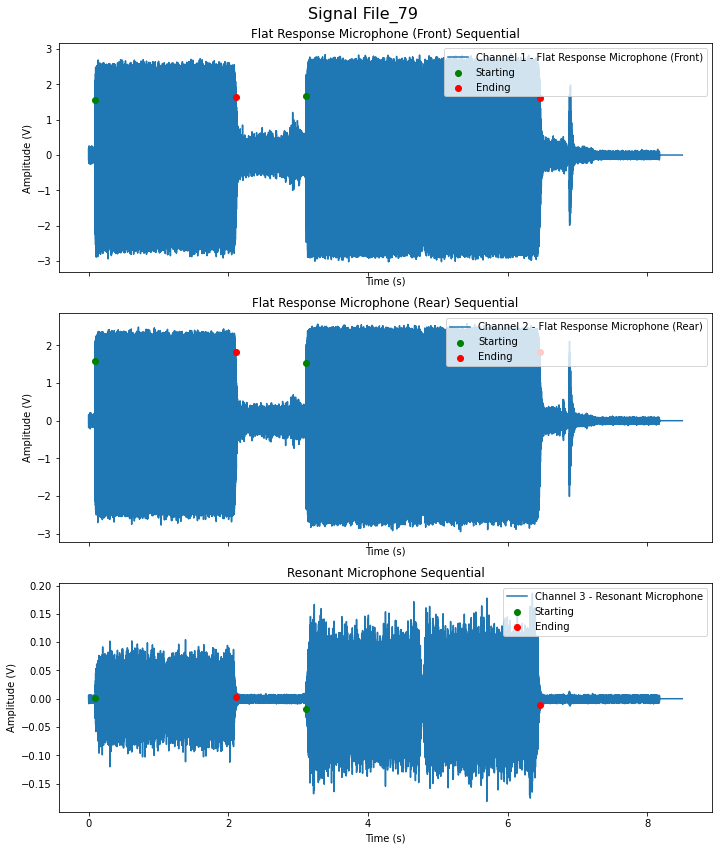

Processing files:  50%|██████████████████████████████                              | 80/160 [20:40<20:57, 15.72s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_80, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_80.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536059.50, Standard Deviation: 134227.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_80.parquet for Channel 2


Processing files:  51%|██████████████████████████████▍                             | 81/160 [20:55<20:33, 15.61s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534974.50, Standard Deviation: 134137.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_80.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534974.50, Standard Deviation: 134137.50, Num. segments: 2

Processing File: File_81, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_81.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536296.50, Standard Deviation: 133918.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_81.parquet for Channel 2


Processing files:  51%|██████████████████████████████▋                             | 82/160 [21:10<20:12, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534647.50, Standard Deviation: 133681.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_81.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534647.50, Standard Deviation: 133681.50, Num. segments: 2

Processing File: File_82, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_82.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536299.50, Standard Deviation: 134323.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_82.parquet for Channel 2


Processing files:  52%|███████████████████████████████▏                            | 83/160 [21:26<19:52, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534866.00, Standard Deviation: 134354.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_82.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534866.00, Standard Deviation: 134354.00, Num. segments: 2

Processing File: File_83, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_83.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536066.00, Standard Deviation: 133942.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_83.parquet for Channel 2


Processing files:  52%|███████████████████████████████▌                            | 84/160 [21:41<19:34, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535696.00, Standard Deviation: 133300.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_83.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535696.00, Standard Deviation: 133300.00, Num. segments: 2

Processing File: File_84, Operation: Sequential, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_84.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536928.50, Standard Deviation: 134425.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_84.parquet for Channel 2


Processing files:  53%|███████████████████████████████▉                            | 85/160 [21:56<19:17, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535789.50, Standard Deviation: 134841.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_84.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535789.50, Standard Deviation: 134841.50, Num. segments: 2

Processing File: File_85, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_85.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670590.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_85.parquet for Channel 2


Processing files:  54%|████████████████████████████████▎                           | 86/160 [22:12<19:00, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668799.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_85.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668799.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_86, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_86.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671979.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_86.parquet for Channel 2


Processing files:  54%|████████████████████████████████▋                           | 87/160 [22:27<18:45, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671095.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_86.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671095.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_87, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_87.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672254.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_87.parquet for Channel 2


Processing files:  55%|█████████████████████████████████                           | 88/160 [22:43<18:28, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671140.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_87.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671140.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_88, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_88.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672640.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_88.parquet for Channel 2


Processing files:  56%|█████████████████████████████████▍                          | 89/160 [22:58<18:13, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671009.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_88.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671009.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_89, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_89.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673543.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_89.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671058.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_89.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proce

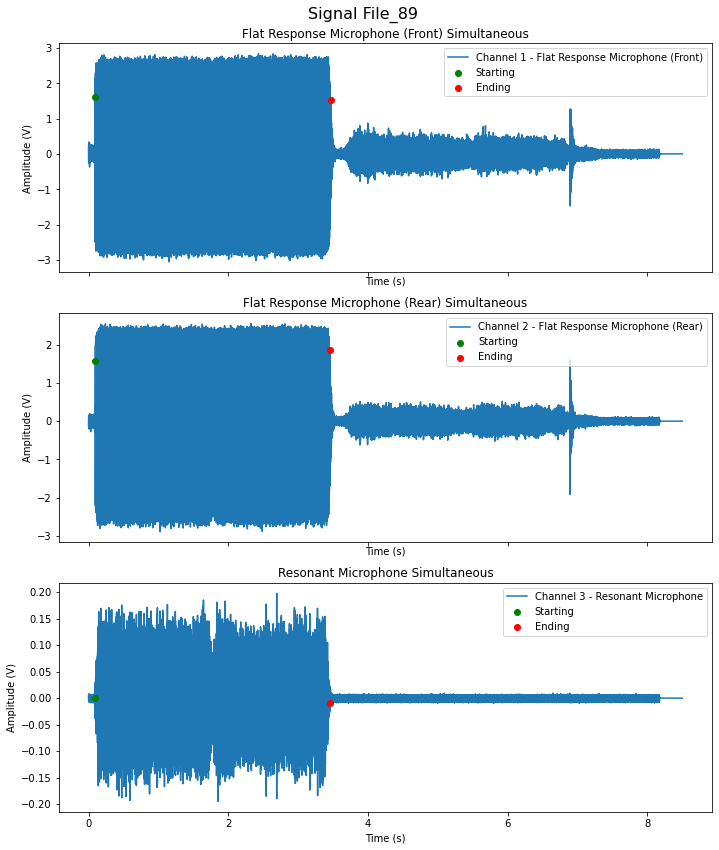

Processing files:  56%|█████████████████████████████████▊                          | 90/160 [23:14<18:18, 15.69s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_90, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_90.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671934.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_90.parquet for Channel 2


Processing files:  57%|██████████████████████████████████▏                         | 91/160 [23:30<17:56, 15.60s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670469.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_90.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670469.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_91, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_91.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671647.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_91.parquet for Channel 2


Processing files:  57%|██████████████████████████████████▌                         | 92/160 [23:45<17:36, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670426.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_91.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670426.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_92, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_92.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673428.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_92.parquet for Channel 2


Processing files:  58%|██████████████████████████████████▉                         | 93/160 [24:00<17:17, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670666.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_92.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670666.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_93, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_93.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671899.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_93.parquet for Channel 2


Processing files:  59%|███████████████████████████████████▎                        | 94/160 [24:16<17:00, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670377.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_93.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670377.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_94, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_94.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672102.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_94.parquet for Channel 2


Processing files:  59%|███████████████████████████████████▋                        | 95/160 [24:31<16:43, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671997.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_94.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671997.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_95, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_95.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672841.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_95.parquet for Channel 2


Processing files:  60%|████████████████████████████████████                        | 96/160 [24:47<16:26, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670781.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_95.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670781.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_96, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_96.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671915.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_96.parquet for Channel 2


Processing files:  61%|████████████████████████████████████▍                       | 97/160 [25:02<16:09, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670208.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_96.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670208.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_97, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_97.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672337.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_97.parquet for Channel 2


Processing files:  61%|████████████████████████████████████▊                       | 98/160 [25:17<15:53, 15.37s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671144.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_97.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671144.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_98, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_98.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672921.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_98.parquet for Channel 2


Processing files:  62%|█████████████████████████████████████▏                      | 99/160 [25:33<15:37, 15.36s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671244.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_98.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671244.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_99, Operation: Simultaneous, Cube 1 Mode: Conduction 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_99.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673238.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_99.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671811.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_99.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proce

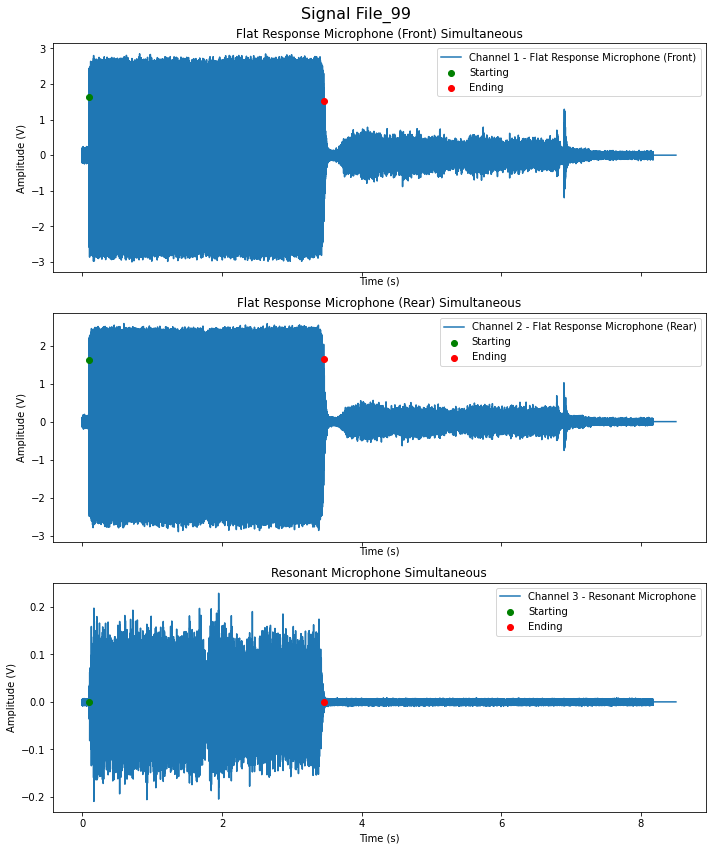

Processing files:  62%|████████████████████████████████████▉                      | 100/160 [25:49<15:38, 15.64s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_100, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_100.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 537224.00, Standard Deviation: 134136.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_100.parquet for Channel 2


Processing files:  63%|█████████████████████████████████████▏                     | 101/160 [26:04<15:17, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535594.50, Standard Deviation: 134529.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_100.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535594.50, Standard Deviation: 134529.50, Num. segments: 2

Processing File: File_101, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_101.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535322.50, Standard Deviation: 135484.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_101.parquet for Channel 2


Processing files:  64%|█████████████████████████████████████▌                     | 102/160 [26:20<14:59, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534897.50, Standard Deviation: 134652.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_101.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534897.50, Standard Deviation: 134652.50, Num. segments: 2

Processing File: File_102, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_102.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536917.00, Standard Deviation: 134240.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_102.parquet for Channel 2


Processing files:  64%|█████████████████████████████████████▉                     | 103/160 [26:35<14:41, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 536526.00, Standard Deviation: 133668.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_102.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 536526.00, Standard Deviation: 133668.00, Num. segments: 2

Processing File: File_103, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_103.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535741.50, Standard Deviation: 134597.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_103.parquet for Channel 2


Processing files:  65%|██████████████████████████████████████▎                    | 104/160 [26:50<14:24, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535103.00, Standard Deviation: 135065.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_103.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535103.00, Standard Deviation: 135065.00, Num. segments: 2

Processing File: File_104, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_104.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536934.50, Standard Deviation: 133560.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_104.parquet for Channel 2


Processing files:  66%|██████████████████████████████████████▋                    | 105/160 [27:06<14:07, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535570.50, Standard Deviation: 133778.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_104.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535570.50, Standard Deviation: 133778.50, Num. segments: 2

Processing File: File_105, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_105.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536035.50, Standard Deviation: 134933.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_105.parquet for Channel 2


Processing files:  66%|███████████████████████████████████████                    | 106/160 [27:21<13:51, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534316.00, Standard Deviation: 134131.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_105.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534316.00, Standard Deviation: 134131.00, Num. segments: 2

Processing File: File_106, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_106.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 537147.00, Standard Deviation: 133812.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_106.parquet for Channel 2


Processing files:  67%|███████████████████████████████████████▍                   | 107/160 [27:37<13:35, 15.39s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 536397.50, Standard Deviation: 133844.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_106.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 536397.50, Standard Deviation: 133844.50, Num. segments: 2

Processing File: File_107, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_107.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536191.00, Standard Deviation: 135076.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_107.parquet for Channel 2


Processing files:  68%|███████████████████████████████████████▊                   | 108/160 [27:52<13:20, 15.39s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534570.00, Standard Deviation: 134717.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_107.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534570.00, Standard Deviation: 134717.00, Num. segments: 2

Processing File: File_108, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_108.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536935.00, Standard Deviation: 133211.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_108.parquet for Channel 2


Processing files:  68%|████████████████████████████████████████▏                  | 109/160 [28:07<13:04, 15.38s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 536265.00, Standard Deviation: 134048.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_108.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 536265.00, Standard Deviation: 134048.00, Num. segments: 2

Processing File: File_109, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_109.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535548.50, Standard Deviation: 134569.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_109.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 535045.50, Standard Deviation: 135014.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_109.parquet for Channel 3
Using vecchia ci

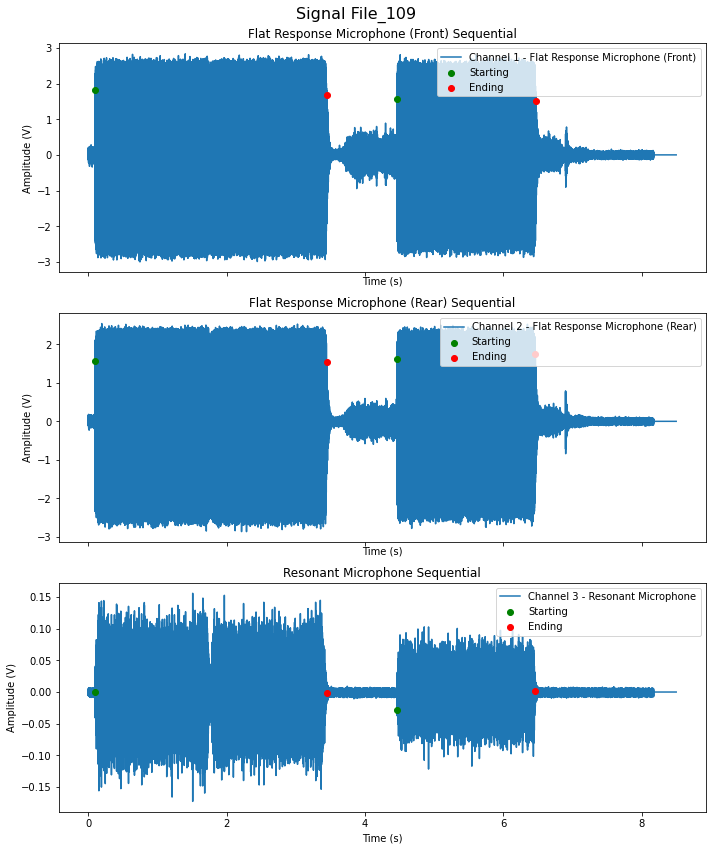

Processing files:  69%|████████████████████████████████████████▌                  | 110/160 [28:24<13:05, 15.72s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_110, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_110.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536742.50, Standard Deviation: 134659.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_110.parquet for Channel 2


Processing files:  69%|████████████████████████████████████████▉                  | 111/160 [28:39<12:44, 15.61s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 536253.00, Standard Deviation: 134196.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_110.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 536253.00, Standard Deviation: 134196.00, Num. segments: 2

Processing File: File_111, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_111.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 535781.50, Standard Deviation: 134989.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_111.parquet for Channel 2


Processing files:  70%|█████████████████████████████████████████▎                 | 112/160 [28:55<12:25, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534868.00, Standard Deviation: 135256.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_111.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534868.00, Standard Deviation: 135256.00, Num. segments: 2

Processing File: File_112, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_112.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536768.00, Standard Deviation: 134217.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_112.parquet for Channel 2


Processing files:  71%|█████████████████████████████████████████▋                 | 113/160 [29:10<12:07, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535223.50, Standard Deviation: 133618.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_112.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535223.50, Standard Deviation: 133618.50, Num. segments: 2

Processing File: File_113, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_113.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536536.50, Standard Deviation: 135729.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_113.parquet for Channel 2


Processing files:  71%|██████████████████████████████████████████                 | 114/160 [29:25<11:50, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 534845.50, Standard Deviation: 134641.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_113.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 534845.50, Standard Deviation: 134641.50, Num. segments: 2

Processing File: File_114, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_114.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 536842.00, Standard Deviation: 134336.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_114.parquet for Channel 2


Processing files:  72%|██████████████████████████████████████████▍                | 115/160 [29:41<11:34, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 535875.00, Standard Deviation: 133694.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_114.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 535875.00, Standard Deviation: 133694.00, Num. segments: 2

Processing File: File_115, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_115.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670741.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_115.parquet for Channel 2


Processing files:  72%|██████████████████████████████████████████▊                | 116/160 [29:56<11:18, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669774.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_115.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669774.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_116, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_116.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670914.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_116.parquet for Channel 2


Processing files:  73%|███████████████████████████████████████████▏               | 117/160 [30:11<11:02, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669046.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_116.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669046.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_117, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_117.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671946.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_117.parquet for Channel 2


Processing files:  74%|███████████████████████████████████████████▌               | 118/160 [30:27<10:46, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669442.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_117.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669442.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_118, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_118.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672610.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_118.parquet for Channel 2


Processing files:  74%|███████████████████████████████████████████▉               | 119/160 [30:42<10:30, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670333.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_118.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670333.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_119, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_119.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672572.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_119.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670032.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_119.parquet for Channel 3
Using vecchia ciabatta
Channel 3: 

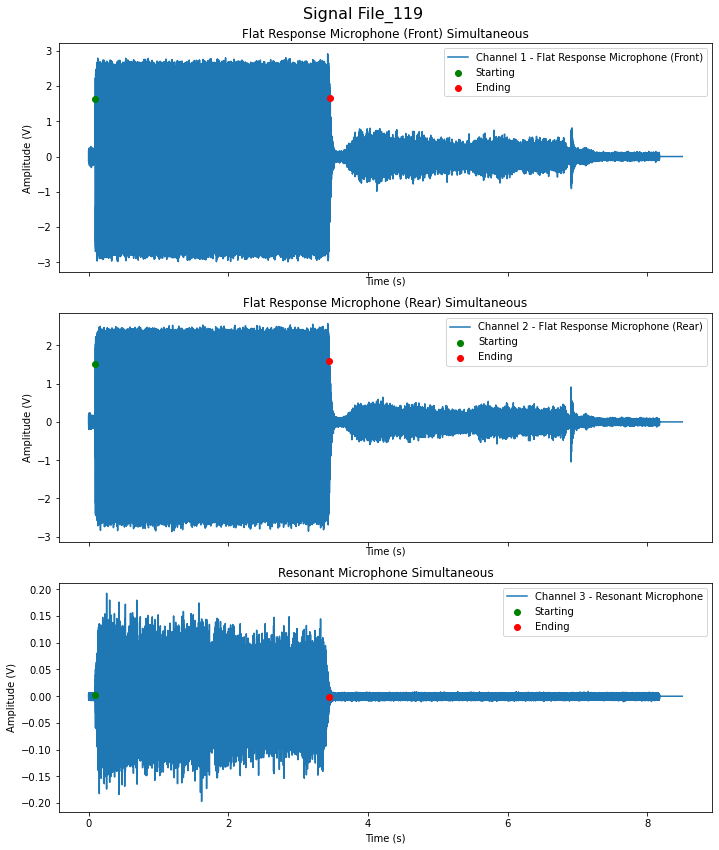

Processing files:  75%|████████████████████████████████████████████▎              | 120/160 [30:58<10:27, 15.68s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_120, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_120.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671293.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_120.parquet for Channel 2


Processing files:  76%|████████████████████████████████████████████▌              | 121/160 [31:14<10:07, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670432.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_120.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670432.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_121, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_121.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671240.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_121.parquet for Channel 2


Processing files:  76%|████████████████████████████████████████████▉              | 122/160 [31:29<09:49, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670009.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_121.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670009.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_122, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_122.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670809.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_122.parquet for Channel 2


Processing files:  77%|█████████████████████████████████████████████▎             | 123/160 [31:45<09:32, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670900.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_122.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670900.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_123, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_123.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671173.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_123.parquet for Channel 2


Processing files:  78%|█████████████████████████████████████████████▋             | 124/160 [32:00<09:16, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669890.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_123.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669890.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_124, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_124.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670056.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_124.parquet for Channel 2


Processing files:  78%|██████████████████████████████████████████████             | 125/160 [32:15<09:00, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669650.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_124.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669650.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_125, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_125.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671068.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_125.parquet for Channel 2


Processing files:  79%|██████████████████████████████████████████████▍            | 126/160 [32:31<08:44, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670527.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_125.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670527.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_126, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_126.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_126.parquet for Channel 2


Processing files:  79%|██████████████████████████████████████████████▊            | 127/160 [32:46<08:28, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670722.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_126.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670722.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_127, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_127.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671285.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_127.parquet for Channel 2


Processing files:  80%|███████████████████████████████████████████████▏           | 128/160 [33:01<08:12, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669974.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_127.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669974.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_128, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_128.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 669885.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_128.parquet for Channel 2


Processing files:  81%|███████████████████████████████████████████████▌           | 129/160 [33:17<07:56, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669085.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_128.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669085.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_129, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Conduction 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_129.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671519.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_129.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 669994.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_129.parquet for Channel 3
Using vecchia ciabatta
Channel 3: 

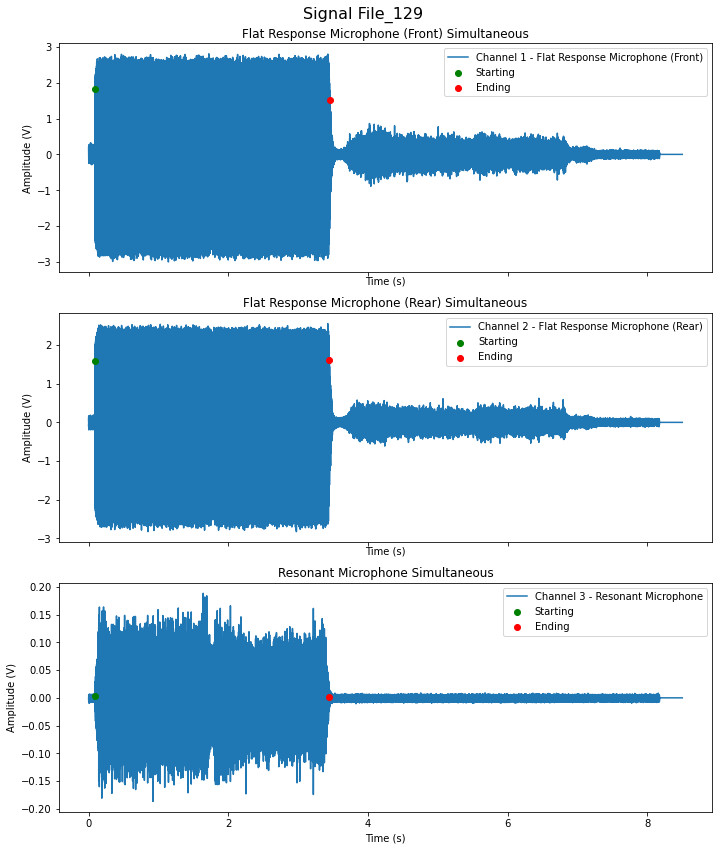

Processing files:  81%|███████████████████████████████████████████████▉           | 130/160 [33:33<07:49, 15.65s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_130, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_130.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671761.00, Standard Deviation: 730.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_130.parquet for Channel 2


Processing files:  82%|████████████████████████████████████████████████▎          | 131/160 [33:49<07:31, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 671395.50, Standard Deviation: 737.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_130.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 671395.50, Standard Deviation: 737.50, Num. segments: 2

Processing File: File_131, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_131.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671071.00, Standard Deviation: 292.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_131.parquet for Channel 2


Processing files:  82%|████████████████████████████████████████████████▋          | 132/160 [34:04<07:15, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669499.00, Standard Deviation: 175.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_131.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669499.00, Standard Deviation: 175.00, Num. segments: 2

Processing File: File_132, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_132.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670705.50, Standard Deviation: 750.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_132.parquet for Channel 2


Processing files:  83%|█████████████████████████████████████████████████          | 133/160 [34:19<06:58, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668962.00, Standard Deviation: 122.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_132.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668962.00, Standard Deviation: 122.00, Num. segments: 2

Processing File: File_133, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_133.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670737.00, Standard Deviation: 1326.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_133.parquet for Channel 2


Processing files:  84%|█████████████████████████████████████████████████▍         | 134/160 [34:35<06:42, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670050.50, Standard Deviation: 1264.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_133.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670050.50, Standard Deviation: 1264.50, Num. segments: 2

Processing File: File_134, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_134.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670887.00, Standard Deviation: 453.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_134.parquet for Channel 2


Processing files:  84%|█████████████████████████████████████████████████▊         | 135/160 [34:50<06:26, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669719.50, Standard Deviation: 595.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_134.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669719.50, Standard Deviation: 595.50, Num. segments: 2

Processing File: File_135, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_135.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670609.50, Standard Deviation: 101.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_135.parquet for Channel 2


Processing files:  85%|██████████████████████████████████████████████████▏        | 136/160 [35:06<06:10, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669031.50, Standard Deviation: 310.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_135.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669031.50, Standard Deviation: 310.50, Num. segments: 2

Processing File: File_136, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_136.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670556.00, Standard Deviation: 89.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_136.parquet for Channel 2


Processing files:  86%|██████████████████████████████████████████████████▌        | 137/160 [35:21<05:54, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669282.00, Standard Deviation: 185.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_136.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669282.00, Standard Deviation: 185.00, Num. segments: 2

Processing File: File_137, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_137.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 669989.00, Standard Deviation: 731.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_137.parquet for Channel 2


Processing files:  86%|██████████████████████████████████████████████████▉        | 138/160 [35:36<05:39, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669463.50, Standard Deviation: 549.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_137.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669463.50, Standard Deviation: 549.50, Num. segments: 2

Processing File: File_138, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_138.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671458.50, Standard Deviation: 841.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_138.parquet for Channel 2


Processing files:  87%|███████████████████████████████████████████████████▎       | 139/160 [35:52<05:24, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669869.00, Standard Deviation: 735.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_138.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669869.00, Standard Deviation: 735.00, Num. segments: 2

Processing File: File_139, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_139.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670604.50, Standard Deviation: 51.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_139.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 669290.50, Standard Deviation: 280.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_139.parquet for Channel 3
Using vecchia ciabatta
Channel 3

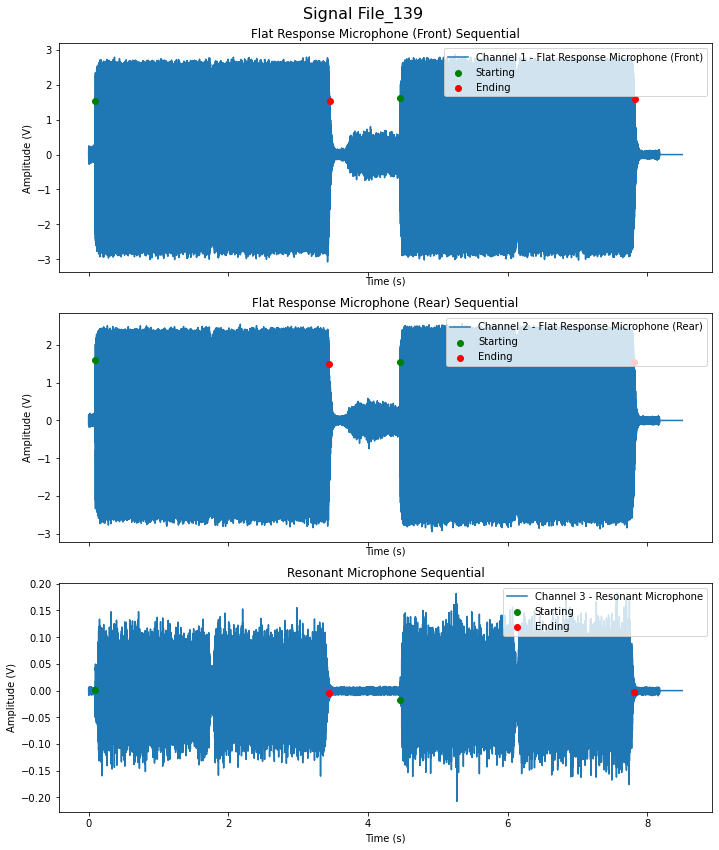

Processing files:  88%|███████████████████████████████████████████████████▋       | 140/160 [36:09<05:16, 15.81s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_140, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_140.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 669806.50, Standard Deviation: 238.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_140.parquet for Channel 2


Processing files:  88%|███████████████████████████████████████████████████▉       | 141/160 [36:24<04:57, 15.68s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669375.50, Standard Deviation: 198.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_140.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669375.50, Standard Deviation: 198.50, Num. segments: 2

Processing File: File_141, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_141.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670340.50, Standard Deviation: 570.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_141.parquet for Channel 2


Processing files:  89%|████████████████████████████████████████████████████▎      | 142/160 [36:39<04:40, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669605.00, Standard Deviation: 429.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_141.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669605.00, Standard Deviation: 429.00, Num. segments: 2

Processing File: File_142, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_142.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670796.00, Standard Deviation: 373.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_142.parquet for Channel 2


Processing files:  89%|████████████████████████████████████████████████████▋      | 143/160 [36:55<04:24, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669458.00, Standard Deviation: 664.00, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_142.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669458.00, Standard Deviation: 664.00, Num. segments: 2

Processing File: File_143, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_143.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670412.50, Standard Deviation: 14.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_143.parquet for Channel 2


Processing files:  90%|█████████████████████████████████████████████████████      | 144/160 [37:10<04:07, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669168.50, Standard Deviation: 194.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_143.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669168.50, Standard Deviation: 194.50, Num. segments: 2

Processing File: File_144, Operation: Sequential, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_144.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670398.50, Standard Deviation: 138.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_2/File_144.parquet for Channel 2


Processing files:  91%|█████████████████████████████████████████████████████▍     | 145/160 [37:26<03:51, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669702.50, Standard Deviation: 44.50, Num. segments: 2
Reading data from ./Raw_data_test/channel_3/File_144.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669702.50, Standard Deviation: 44.50, Num. segments: 2

Processing File: File_145, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_145.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672403.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_145.parquet for Channel 2


Processing files:  91%|█████████████████████████████████████████████████████▊     | 146/160 [37:41<03:36, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671085.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_145.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671085.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_146, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_146.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674202.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_146.parquet for Channel 2


Processing files:  92%|██████████████████████████████████████████████████████▏    | 147/160 [37:56<03:20, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672272.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_146.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672272.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_147, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_147.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673426.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_147.parquet for Channel 2


Processing files:  92%|██████████████████████████████████████████████████████▌    | 148/160 [38:12<03:04, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671860.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_147.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671860.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_148, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_148.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673086.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_148.parquet for Channel 2


Processing files:  93%|██████████████████████████████████████████████████████▉    | 149/160 [38:27<02:49, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671943.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_148.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671943.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_149, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_149.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673413.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_149.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672573.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_149.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pro

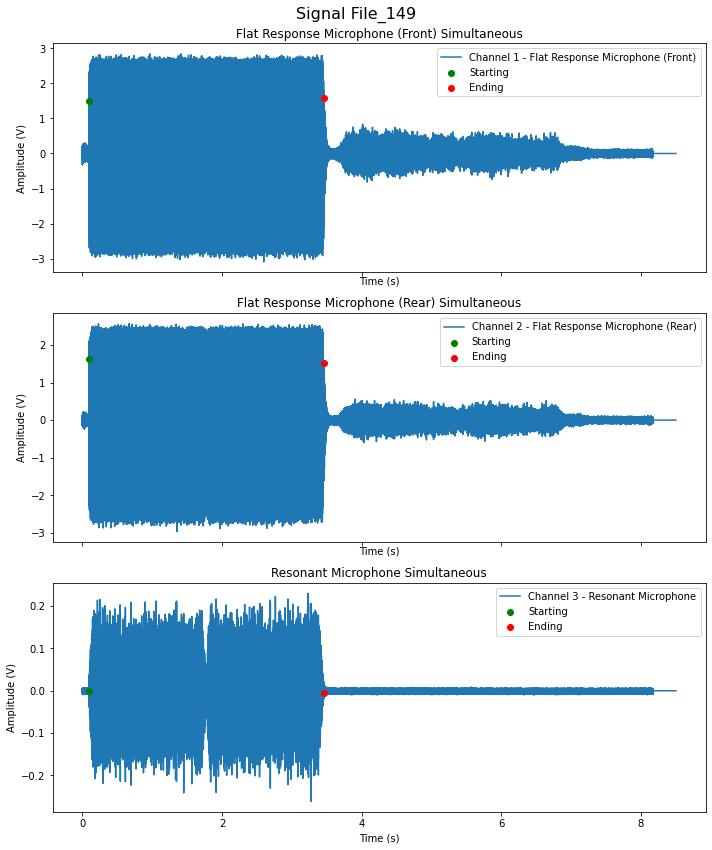

Processing files:  94%|███████████████████████████████████████████████████████▎   | 150/160 [38:43<02:36, 15.68s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_150, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_150.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672406.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_150.parquet for Channel 2


Processing files:  94%|███████████████████████████████████████████████████████▋   | 151/160 [38:59<02:20, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671672.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_150.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671672.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_151, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_151.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674035.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_151.parquet for Channel 2


Processing files:  95%|████████████████████████████████████████████████████████   | 152/160 [39:14<02:04, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671850.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_151.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671850.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_152, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_152.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672213.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_152.parquet for Channel 2


Processing files:  96%|████████████████████████████████████████████████████████▍  | 153/160 [39:29<01:48, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671183.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_152.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671183.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_153, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_153.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672811.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_153.parquet for Channel 2


Processing files:  96%|████████████████████████████████████████████████████████▊  | 154/160 [39:45<01:32, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672504.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_153.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672504.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_154, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_154.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674016.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_154.parquet for Channel 2


Processing files:  97%|█████████████████████████████████████████████████████████▏ | 155/160 [40:00<01:17, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672202.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_154.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672202.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_155, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_155.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673547.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_155.parquet for Channel 2


Processing files:  98%|█████████████████████████████████████████████████████████▌ | 156/160 [40:16<01:01, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671443.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_155.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671443.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_156, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_156.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672668.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_156.parquet for Channel 2


Processing files:  98%|█████████████████████████████████████████████████████████▉ | 157/160 [40:31<00:46, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671704.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_156.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671704.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_157, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_157.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673925.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_157.parquet for Channel 2


Processing files:  99%|██████████████████████████████████████████████████████████▎| 158/160 [40:46<00:30, 15.36s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672743.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_157.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672743.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_158, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_158.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672944.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_158.parquet for Channel 2


Processing files:  99%|██████████████████████████████████████████████████████████▋| 159/160 [41:02<00:15, 15.35s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672127.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_158.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672127.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_159, Operation: Simultaneous, Cube 1 Mode: Keyhole 4, Cube 2 Mode: Keyhole 4
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data_test/channel_1/File_159.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673686.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_2/File_159.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671722.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data_test/channel_3/File_159.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Pro

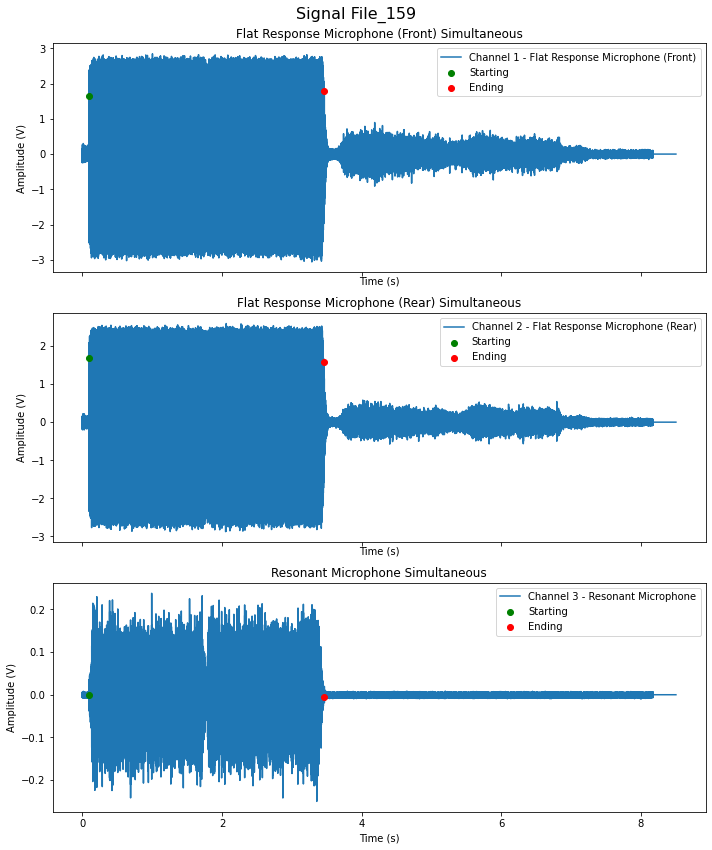

Processing files: 100%|███████████████████████████████████████████████████████████| 160/160 [41:18<00:00, 15.49s/it]

--------------------------------------------------------------------------------------------------------------------------------


In [8]:
data_path = './Raw_data_test/'

all_processed_data = parse_multimodal_signals_corrected_with_plotting(data_path, threshold=1.5)

In [9]:
import pickle

# Save the dictionary with pickle
with open('my_dic_TEST.pkl', 'wb') as file:
    pickle.dump(all_processed_data, file)

In [10]:
def analyze_all_processed_data(all_processed_data):
    for file_name, data in all_processed_data.items():
        print(f"File {file_name}:")
        
        # Processed Data Analysis
        for channel_key, channel_info in data.items():
            num_segments = len(channel_info['segments'])
            mode = channel_info['Operation']
            print(f"  {channel_key}: {num_segments} segments detected, mode: {mode}")

        print('----'*20)

In [11]:
analyze_all_processed_data(all_processed_data)

File File_0:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_1:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_2:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_3:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_4: